In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
import seaborn as sns
import math
import ast
import progressbar
import os

# import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap
import statsmodels.formula.api as smf


# Cleaning Dataset (todo in P3 main file)

In [2]:
actors = pd.read_pickle("./data/actors.pkl")
movies = pd.read_pickle("./data/movies.pkl").set_index('IMDb_ID')

actors_movies_all = actors.droplevel(0, axis=1).merge(movies['averageRating'],left_on='IMDb_ID', right_index=True)
actors_movies_all = actors_movies_all.drop(columns=['birthYear', 'movie_count_genre'])
actors_movies_all = actors_movies_all.replace("\\N", pd.NA)

In [3]:
import networkx as nx
# Create an empty dictionary to store centrality values for each year
centrality_dict = {}

# Create an empty graph
B = nx.Graph()

# Loop over unique years
for year in actors_movies_all['Movie release date'].unique():
    # Filter the DataFrame up to the current year
    current_year_data = actors_movies_all[actors_movies_all['Movie release date'] <= year]

    # Add nodes with the 'bipartite' attribute
    B.add_nodes_from(current_year_data.index.get_level_values('IMDb_actor_ID'), bipartite=0)
    B.add_nodes_from(current_year_data.index.get_level_values('IMDb_ID'), bipartite=1)

    # Add edges between actors and movies
    B.add_edges_from(current_year_data.index)

    # Project the bipartite graph onto the actor nodes
    actor_graph = nx.bipartite.projected_graph(B, nodes=current_year_data.index.get_level_values('IMDb_actor_ID'))

    # Calculate the degree of centrality
    centrality = nx.degree_centrality(actor_graph)

    # Add centrality values to the dictionary for the current year
    centrality_dict[year] = centrality.copy()



In [5]:
# Convert the dictionary of centrality values to a DataFrame
centrality_df = pd.DataFrame.from_dict(centrality_dict, orient='columns').stack().to_frame().reset_index()
centrality_df = centrality_df.rename(columns={"level_0": "IMDb_actor_ID", "level_1": "Movie release date", 0:"actor_connections"})

tmp=actors_movies_all.reset_index()
actors_movies_all = pd.merge(tmp,centrality_df, on=["IMDb_actor_ID","Movie release date"], how = "inner")
actors_movies_all=actors_movies_all.set_index(['IMDb_ID','IMDb_actor_ID'])

In [6]:
# Input:
#   - year (int)
#   - range (int)
# Output:
#   - Range (str)
def create_range(year, range=10):
    start_range = (year // range) * range
    return "{} - {}".format(start_range, start_range + range)


actors_movies_all = actors_movies_all.sort_values(by='Movie release date')
actors_movies_all['ReleaseYearRange'] = actors_movies_all['Movie release date'].apply(lambda x: create_range(x))

In [28]:
# Calculate the 30th and 70th percentiles
low_threshold = actors_movies_all['averageRating'].quantile(0.05)
high_threshold = actors_movies_all['averageRating'].quantile(0.95)

# Filter the DataFrame to keep only the rows in the lowest 30% and highest 30%
actors_movies = actors_movies_all[(actors_movies_all['averageRating'] <= low_threshold) | (actors_movies_all['averageRating'] >= high_threshold)].copy()
actors_movies['is_good'] = actors_movies['averageRating']> 6

In [8]:
display(actors_movies)

ordering  Wikipedia movie ID  \
IMDb_ID   IMDb_actor_ID                                 
tt0020629 nm0938464             2             4592959   
tt0020982 nm0393028             1            31211258   
          nm0345073             2            31211258   
          nm0908963             3            31211258   
tt0021202 nm0820607             3            29472951   
...                           ...                 ...   
tt2342061 nm0712433             1            34528861   
tt1714203 nm0000609             2            31879136   
tt2071445 nm0265492             2            35667098   
tt2342061 nm2299825             2            34528861   
tt1684225 nm0000430             2            32846589   

                                             Movie name  Movie release date  \
IMDb_ID   IMDb_actor_ID                                                       
tt0020629 nm0938464      All Quiet on the Western Front                1930   
tt0020982 nm0393028                          Hokuspokus                1930   
          nm0345073                          Hokuspokus                1930   
          nm0908963                          Hokuspokus                1930   
tt0021202 nm0820607                The Oklahoma Cyclone                1930   
...                                                 ...                 ...   
tt2342061 nm0712433            Devudu Chesina Manushulu                2012   
tt1714203 nm0000609                         Piranha 3DD                2012   
tt2071445 nm0265492                            Deranged                2012   
tt2342061 nm2299825            Devudu Chesina Manushulu                2012   
tt1684225 nm0000430                      I Heart Shakey                2012   

                              primaryName  awards  nominations  movie_count  \
IMDb_ID   IMDb_actor_ID                                                       
tt0020629 nm0938464         Louis Wolheim       0            0            3   
tt0020982 nm0393028         Oscar Homolka       0            0            1   
          nm0345073      Gustaf Gründgens       0            0            1   
          nm0908963         Otto Wallburg       0            0            1   
tt0021202 nm0820607           Al St. John       0            0            1   
...                                   ...     ...          ...          ...   
tt2342061 nm0712433             Ravi Teja       0            0           11   
tt1714203 nm0000609           Ving Rhames       0            0           19   
tt2071445 nm0265492       Craig Fairbrass       0            0            5   
tt2342061 nm2299825         Ileana D'Cruz       0            0            4   
tt1684225 nm0000430      Steve Guttenberg       0            0           23   

                         genres_b4  isMale  age_at_release  averageRating  \
IMDb_ID   IMDb_actor_ID                                                     
tt0020629 nm0938464              1       1              50            8.1   
tt0020982 nm0393028              4       1              32            7.6   
          nm0345073              1       1              31            7.6   
          nm0908963              1    <NA>              41            7.6   
tt0021202 nm0820607              1    <NA>              37            3.8   
...                            ...     ...             ...            ...   
tt2342061 nm0712433              1       1              44            3.7   
tt1714203 nm0000609              1       1              53            3.8   
tt2071445 nm0265492              1       1              48            3.0   
tt2342061 nm2299825              1       0              25            3.7   
tt1684225 nm0000430             39       1              54            3.6   

                         actor_connections ReleaseYearRange  is_good  \
IMDb_ID   IMDb_actor_ID                                                
tt0020629 nm0938464               0.003747      1930 - 1940     True   
tt0020982

# Correlation Features with Ratings

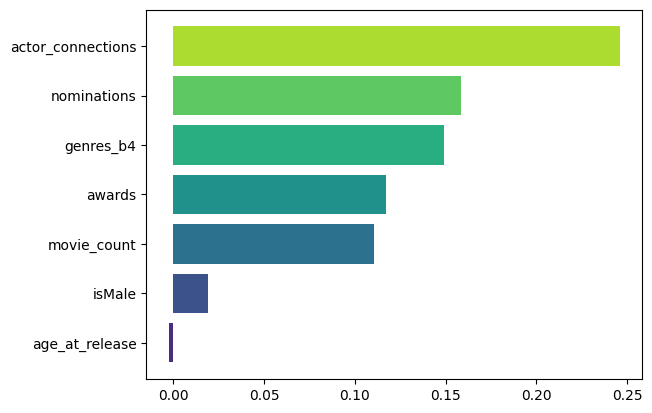

In [23]:
correlation_matrix=actors_movies[[ 'awards', 'nominations', 'movie_count', 'genres_b4', 'isMale', 'age_at_release','averageRating', 'actor_connections']].corr()
correlation_with_X = correlation_matrix['averageRating'].drop('averageRating')  # Remove correlation with itself
correlation_with_X_sorted = correlation_with_X.sort_values()
# Create a horizontal bar plot
plt.barh(correlation_with_X_sorted.index, correlation_with_X_sorted, color=sns.color_palette('viridis', n_colors=len(correlation_with_X_sorted)))
plt.show()

-> NOW LETS ANALYSE PER YEAR

# Visualizing the evolution of features over time

C:\Users\kelan\AppData\Local\Temp\ipykernel_21276\3841899864.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  lo.loc[:, 'Category'] = 'bellow {}'.format(globals()[cat])
C:\Users\kelan\AppData\Local\Temp\ipykernel_21276\3841899864.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  hi.loc[:, 'Category'] = 'above {}'.format(globals()[cat])
C:\Users\kelan\AppData\Local\Temp\ipykernel_21276\3841899864.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.
  lo_filtered.loc[:, y] = pd.to_numeric(lo_filtered[y])
C:\Users\kelan\AppData\Local\Temp\ipykernel_21276\3841899864.py:22: PerformanceWarning: indexing past lexsort depth may impact performance.
  hi_filtered.loc[:, y] = pd.to_numeric(hi_filtered[y])
C:\Users\kelan\AppData\Local\Temp\ipykernel_21276\3841899864.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.
  lo_filtered.loc[:, y] = pd.to_numeric(lo_filtered[y])
C:\Users\ke

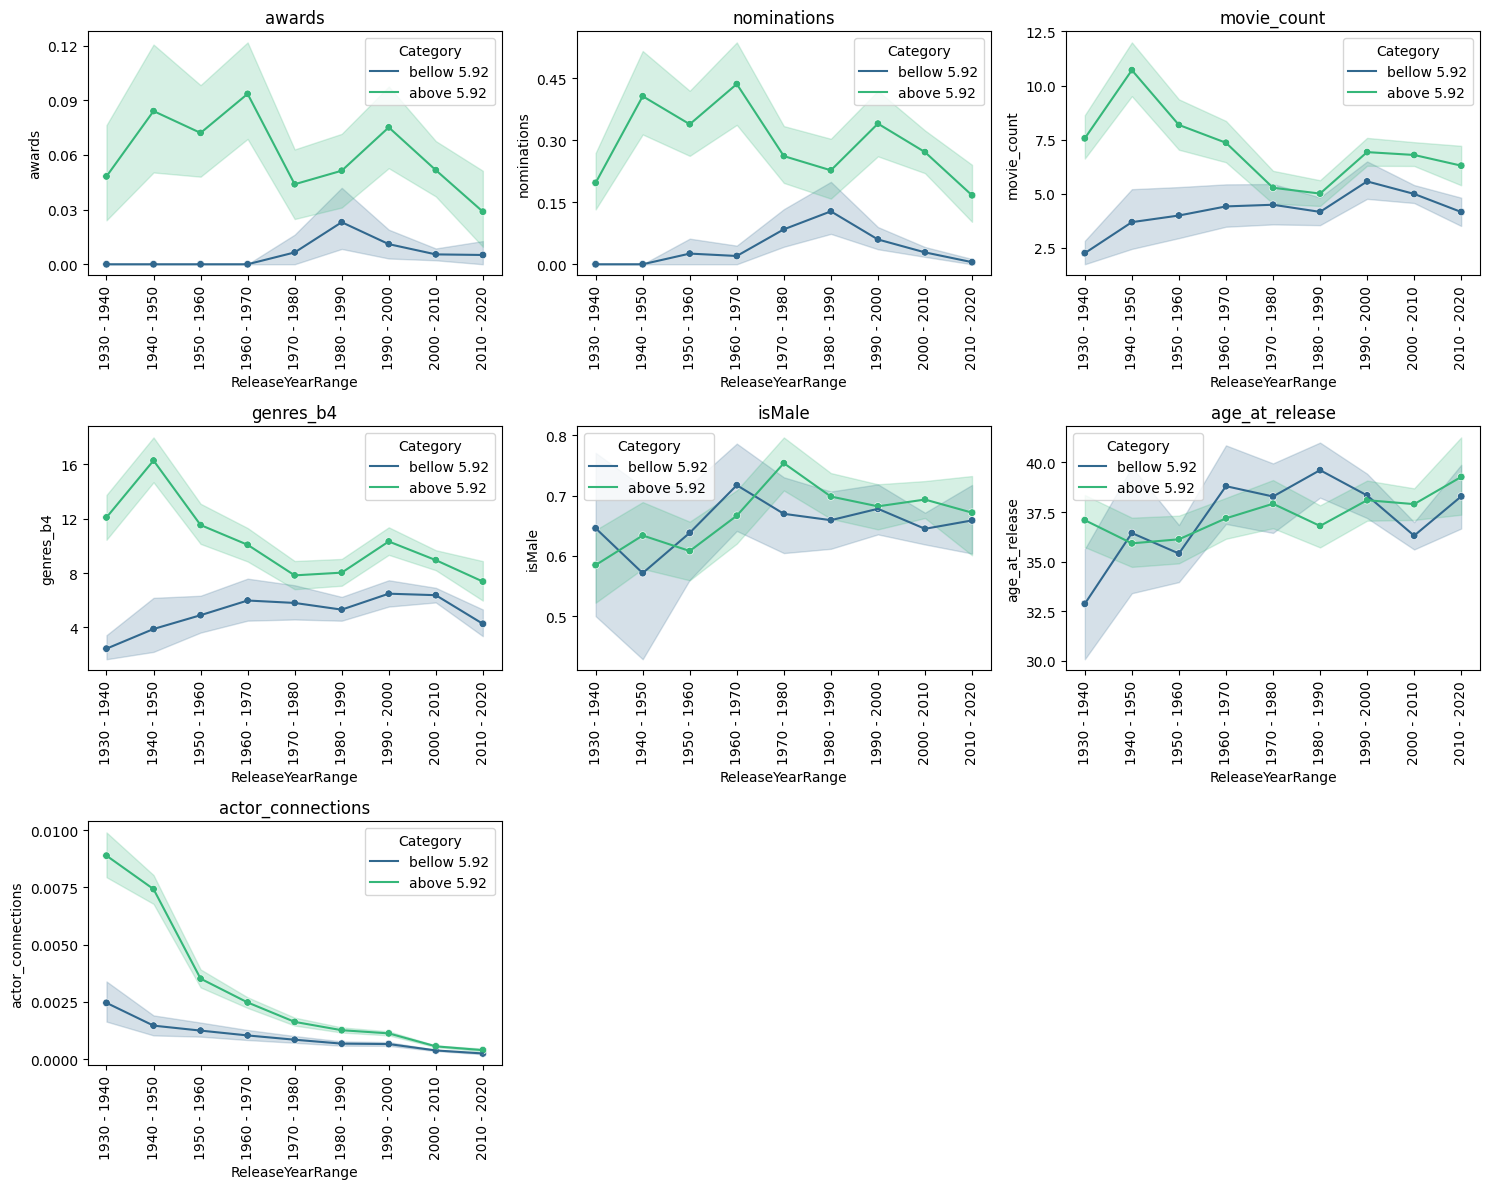

In [ ]:
def do_fancy_ecpi_cute_plot(df, cat, diff, x, y_list, titles, ncols=3, max_y_ticks=5):

    nrows = -(-len(y_list) // ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))

    lo = df.query(f'{diff} < @{cat}').copy()
    hi = df.query(f'{diff} >= @{cat}').copy()
    # me = df.copy()
    
    lo.loc[:, 'Category'] = 'bellow {}'.format(globals()[cat])
    hi.loc[:, 'Category'] = 'above {}'.format(globals()[cat])
    # me.loc[:, 'Category'] = 'mean'

    for i, (y, title) in enumerate(zip(y_list, titles)):

        lo_filtered = lo[lo[y].notna()]
        hi_filtered = hi[hi[y].notna()]
        # me_filtered = me[me[y].notna()]

        lo_filtered.loc[:, y] = pd.to_numeric(lo_filtered[y])
        hi_filtered.loc[:, y] = pd.to_numeric(hi_filtered[y])
        # me_filtered.loc[:, y] = pd.to_numeric(me_filtered[y])
        
        lo_filtered_mean = lo_filtered.groupby(x)[y].mean().reset_index()
        lo_filtered_mean['Category'] = 'bellow {}'.format(globals()[cat])

        hi_filtered_mean = hi_filtered.groupby(x)[y].mean().reset_index()
        hi_filtered_mean['Category'] = 'above {}'.format(globals()[cat])

        # me_filtered_mean = me_filtered.groupby(x)[y].mean().reset_index()
        # me_filtered_mean['Category'] = 'mean'

        # frame = pd.concat([lo_filtered, hi_filtered, me_filtered])
        frame = pd.concat([lo_filtered, hi_filtered])

        # frame_mean = pd.concat([lo_filtered_mean, hi_filtered_mean, me_filtered_mean])
        frame_mean = pd.concat([lo_filtered_mean, hi_filtered_mean])
    
        ax = axes[i // ncols, i % ncols]
        sns.lineplot(data=frame, x=x, y=y, hue='Category', errorbar='ci', palette='viridis', ax=ax)
        sns.scatterplot(data=frame_mean, x=x, y=y, hue='Category', palette='viridis', ax=ax, legend=False, marker='o', s=30)
        ax.set_title(title)
        ax.legend(title='Category')

        # Rotate x-axis labels
        for label in ax.get_xticklabels():
            label.set_rotation(90)

        # Set y-axis tick frequency
        ax.yaxis.set_major_locator(MaxNLocator(nbins=max_y_ticks))
    

    # Turn off any unused subplots
    for j in range(i + 1, nrows * ncols):
        axes[j // ncols, j % ncols].axis('off')

    plt.tight_layout()
    plt.show()

mean_rating = round(actors_movies['averageRating'].mean(), 2)
do_fancy_ecpi_cute_plot(actors_movies, 'mean_rating', 'averageRating', 'ReleaseYearRange', 
                        ['awards', 'nominations', 'movie_count', 'genres_b4', 'isMale', 'age_at_release', 'actor_connections'], 
                        ['awards', 'nominations', 'movie_count', 'genres_b4', 'isMale', 'age_at_release', 'actor_connections'])

THINGS TO NOTE:
- THERE SEEMS TO BE A CORRELATION BETWEEN SOME FEATURES (SEE LATER)
- AWARDS/NOMINATIONS & MOVIE COUNT/ GENRES B4 & ACTOR CONNECTIONS SEEM TO HAVE THE MOST INFLUENCE BUT THAT INFLUENCE CHANGES OVER TIME (SEE LATER)
- AWARDS/NOMINATIONS ARE ALWAYS SIGNINFICANT (C.Is DONT OVERLAP)

# Feature Correlation

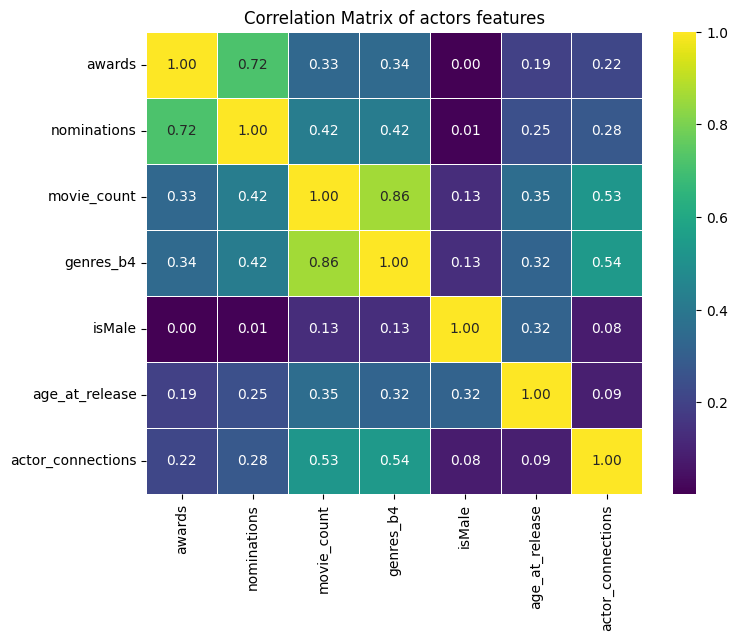

In [22]:
# Calculate the correlation matrix
correlation_matrix = actors_movies[['awards', 'nominations', 'movie_count', 'genres_b4', 'isMale', 'age_at_release', 'actor_connections']].corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="viridis", fmt=".2f", linewidths=.5)

plt.title('Correlation Matrix of actors features')
plt.show()

- Awards: Actors in movies rated above 6.03 tend to have accumulated more awards across the years compared to those in movies with ratings below 6.03.

- Nominations: Similarly, actors in higher-rated movies have received more nominations over the years.

- Movie Count: Actors in higher-rated movies have appeared in a greater number of movies, especially in the time frame from the 1940s to the early 2000s.

- Genres Before Current Movie (genres_b4): Actors in higher-rated movies have tended to play in a greater variety of genres before their current movie, with the difference being most pronounced in the early release years.

- IsMale (Gender Distribution): The proportion of male actors varies with time, and there's a higher proportion of male actors in movies above the 6.03 rating threshold in certain time periods. However, the overlapping confidence intervals suggest a significant variance in the data.

- Age at Release: Actors in higher-rated movies are generally older, particularly noticeable from the 1980s onward, whereas in earlier decades, the trend is not as distinct.

The plots suggest there are observable differences in the features of actors between high and low-rated movies. Specifically, actors in higher-rated movies have a history of more awards and nominations, have appeared in more movies, have had experience across a wider range of genres before the current movie, and are typically older at the time of the movie's release. The gender distribution is somewhat variable and does not show as clear a trend. These findings indicate that actors' experience and recognition (in terms of awards and variety of roles) may correlate with the ratings of the movies they are in.

# Correlation over the years

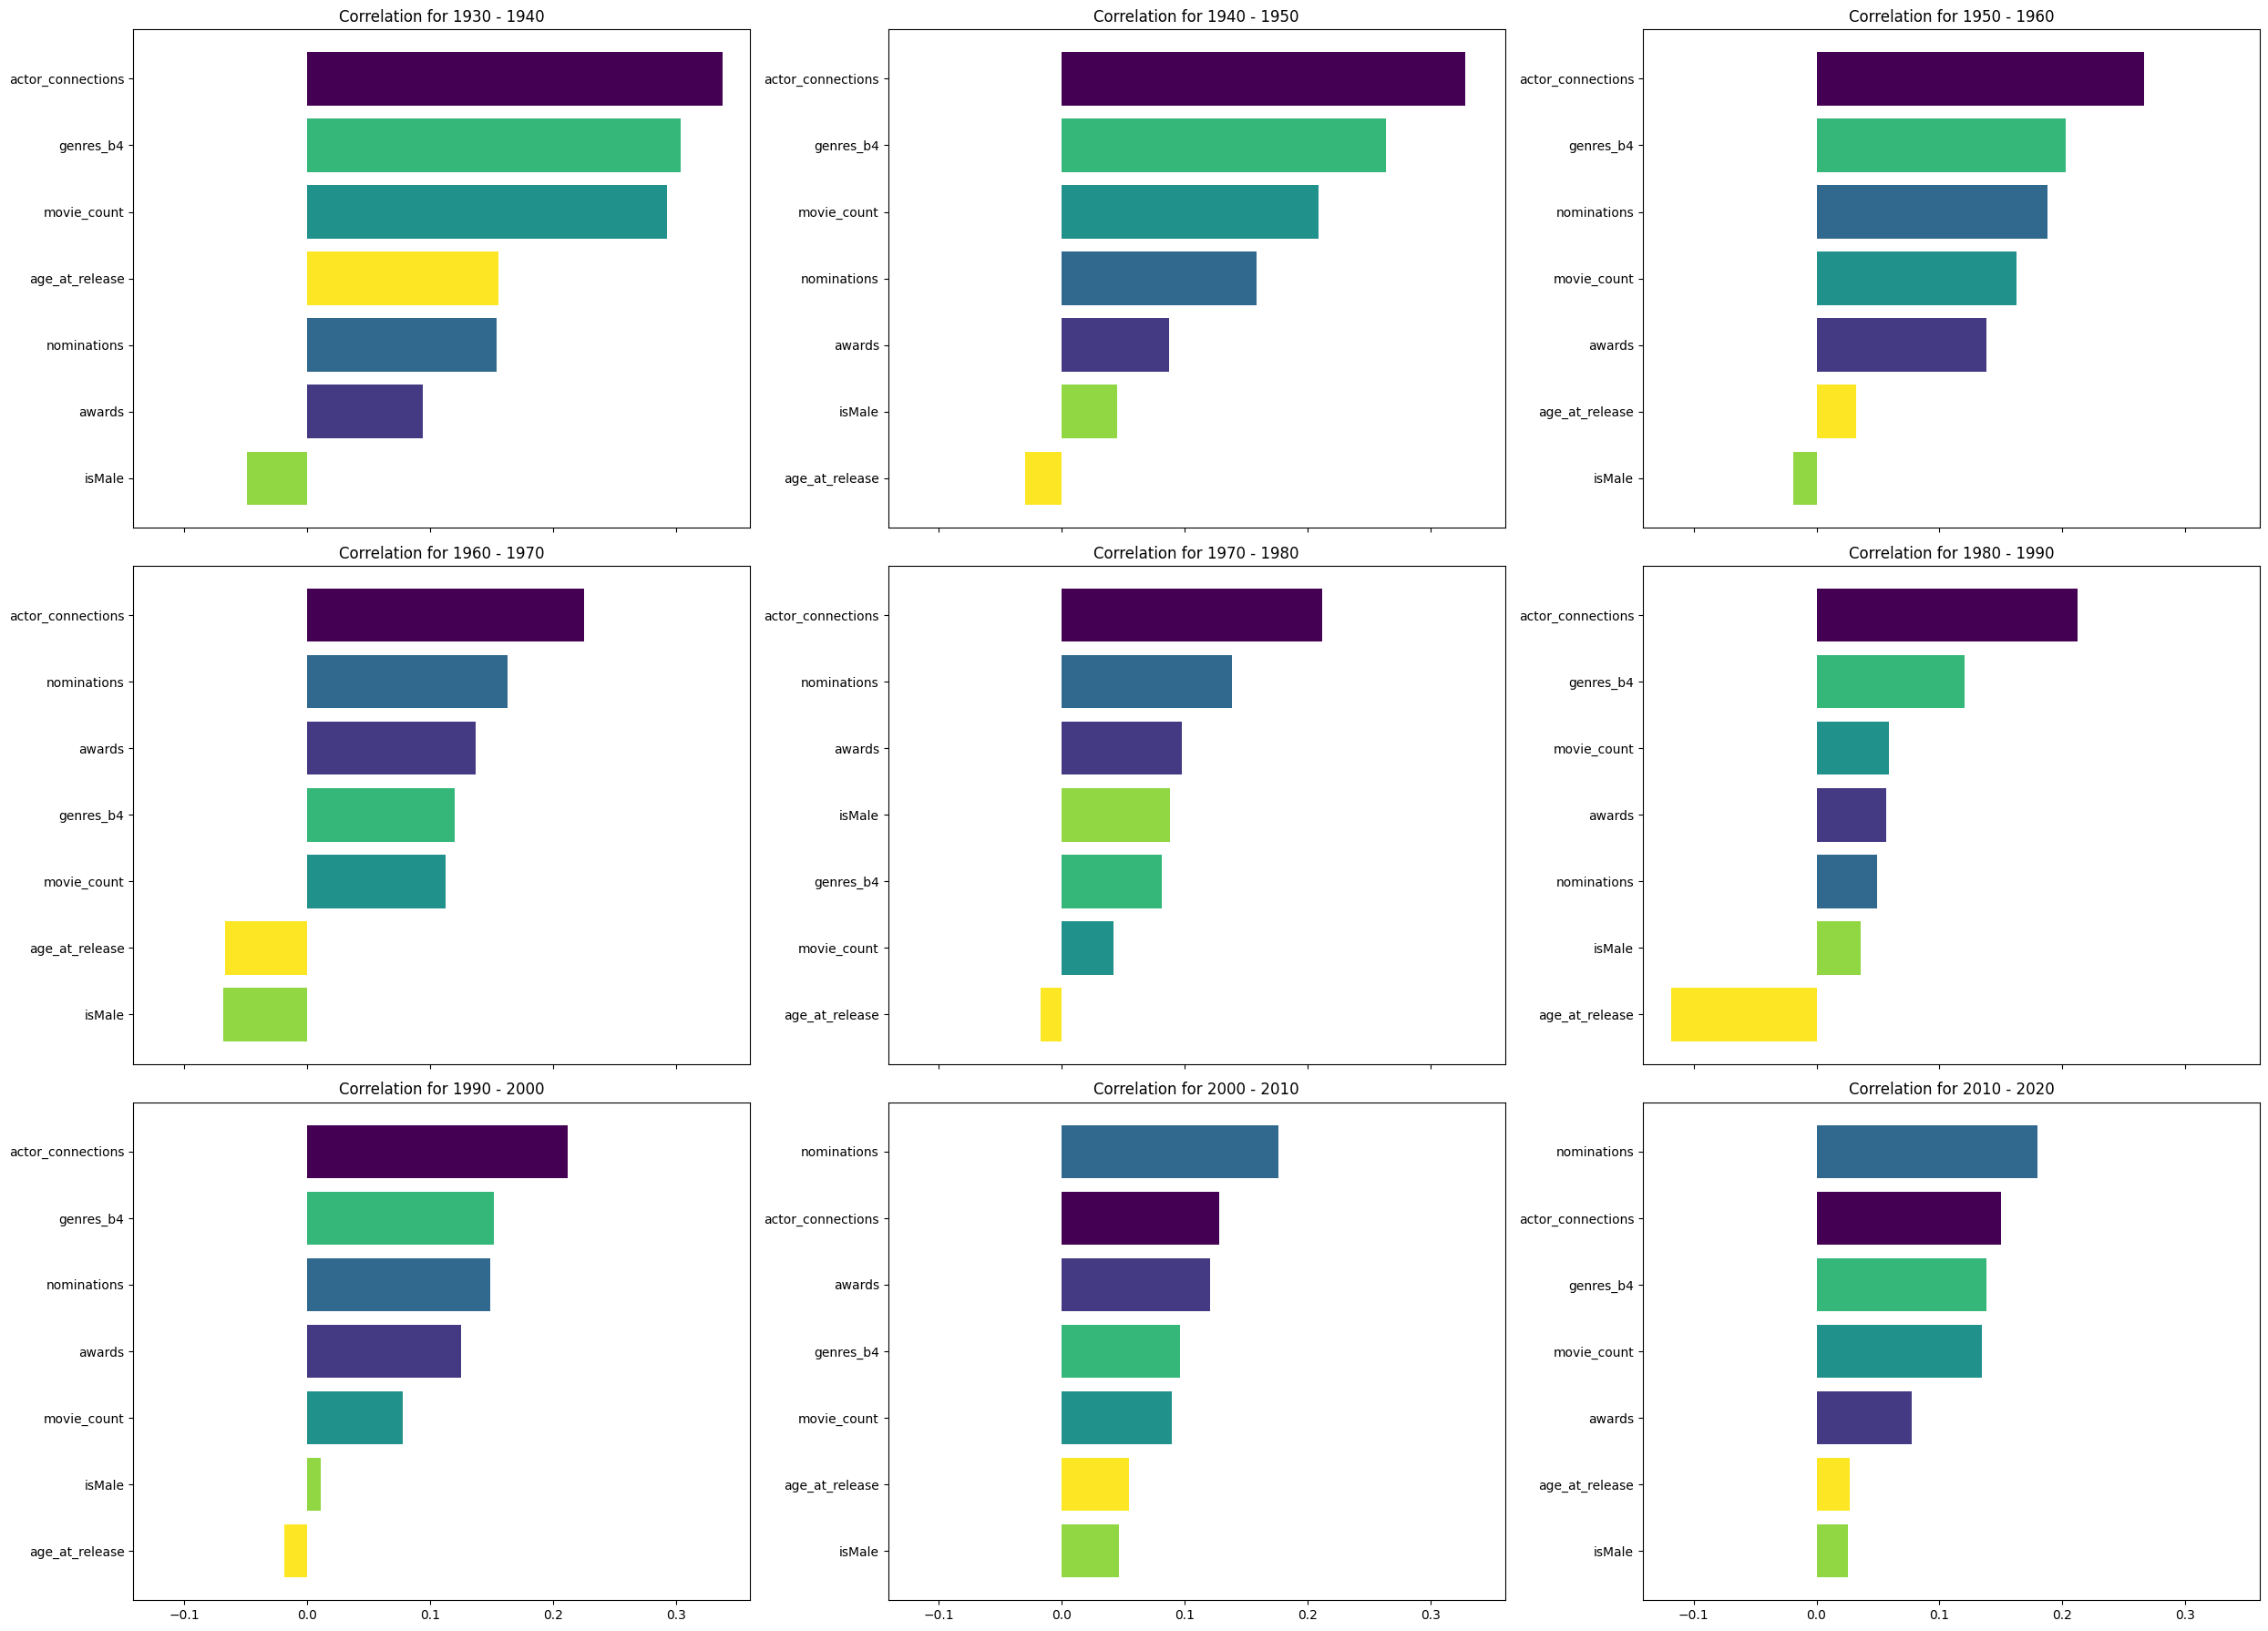

In [24]:
figs, axs = plt.subplots(3, 3, figsize=(25, 18))
axs = axs.flatten()
Years = actors_movies['ReleaseYearRange'].unique()

# Define a colormap
cmap = plt.cm.viridis

# List of features
features = [ 'actor_connections','awards', 'nominations', 'movie_count', 'genres_b4', 'isMale', 'age_at_release']

# Map each feature to a numerical value
feature_values = np.linspace(0, 1, len(features))
feature_colors = {feature: cmap(value) for feature, value in zip(features, feature_values)}

for i, year_range in enumerate(Years):
    Year = actors_movies[actors_movies['ReleaseYearRange'] == year_range]
    
    # Reset the index of Year to ensure alignment
    Year.reset_index(drop=True, inplace=True)

    correlation_matrix = Year[features + ['averageRating']].corr()
    correlation_with_X = correlation_matrix['averageRating'].drop('averageRating')
    correlation_with_X_sorted = correlation_with_X.sort_values()

    # Get colors for each feature
    colors = [feature_colors[feature] for feature in correlation_with_X_sorted.index]

    # Create a horizontal bar plot with specified colors
    axs[i].barh(correlation_with_X_sorted.index, correlation_with_X_sorted, color=colors)
    axs[i].set_title(f'Correlation for {year_range}')

plt.tight_layout()
plt.show()

THE SAME FEATURES AS MENTIONED ABOVE ARE CORELATED WITH RAITING BUT IN VARING ORDERS
- FAIRE UNE ANALYSE SUR LA QUANTITE ( AU DéBUT GRAND CORRELATION, MOINS APRèS)

# Feature analysis

Now we know what features are important and when, lets have a better look at them

## 1. Awards/Nominations
Since the awards/nominations have are statistically significant over the whole range of years, we are going to analyse it's impact overall

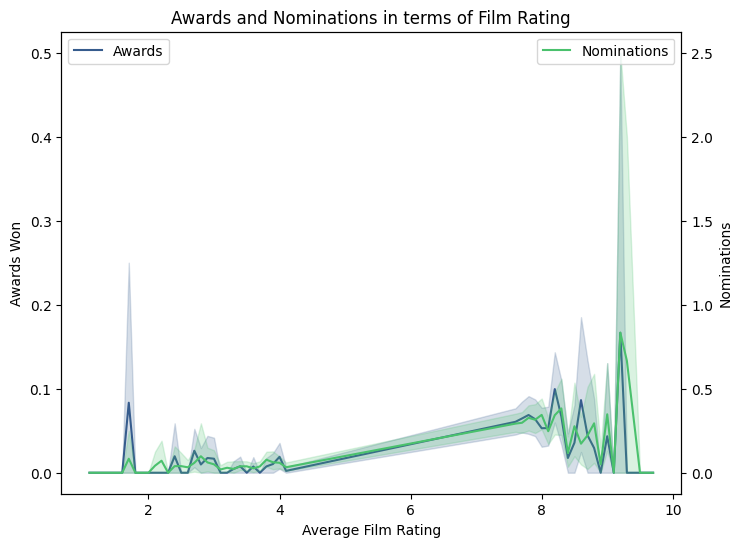

In [26]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot on the first y-axis
sns.lineplot(x='averageRating', y='awards', data=actors_movies, errorbar=('ci', 95), ax=ax1, label='Awards', color=sns.color_palette('viridis')[1])
ax1.set_xlabel("Average Film Rating")
ax1.set_ylabel("Awards Won")

# Create a second y-axis and plot on it
ax2 = ax1.twinx()
sns.lineplot(x='averageRating', y='nominations', data=actors_movies, errorbar=('ci', 95), ax=ax2, label='Nominations',color=sns.color_palette('viridis')[4])
ax2.set_ylabel("Nominations")

# Display legends for both lines
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adjust layout
plt.title("Awards and Nominations in terms of Film Rating")
plt.show()

Here we are plotting the average awards won/nominations per rating.As mentionned before, we can see the correlations between these two plots. We can also observe a steady rise in awards won and nominations as the raiting increases meaning that films with high ratings generally have more oscars and nominations. Unfortunalty, we don't have enough data in the higher film ratings, hence the high confidence interval.

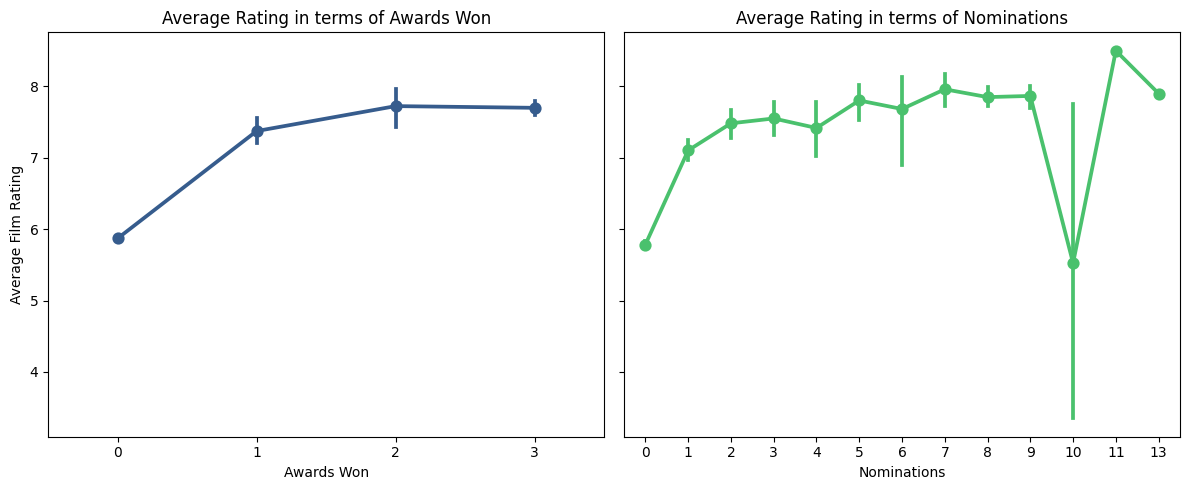

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot 1
plt.subplot(1, 2, 1)
sns.pointplot(x='awards', y='averageRating', data=actors_movies, errorbar=('ci', 95), color=sns.color_palette('viridis')[1])
plt.title("Average Rating in terms of Awards Won")
plt.xlabel("Awards Won")
plt.ylabel("Average Film Rating")

# Plot 2
plt.subplot(1, 2, 2)
sns.pointplot(x='nominations', y='averageRating', data=actors_movies, errorbar=('ci', 95), color=sns.color_palette('viridis')[4])
plt.title("Average Rating in terms of Nominations")
plt.xlabel("Nominations")

plt.tight_layout()
plt.show()

These two plots show that there is indeed a significant difference in movie ratings in terms of oscars won and nominations recieved. In other words, actors with oscars and nominations generelly play in better rated films. 

On the nominations plot, the confidence interval explodes after 6 nominations due to little data, however before that we can see an significant incresing trend before that.

Another interesting observation is that we can we can distinguish films with and without awards, as having more than one award is not statistical significant.

To simplyfiy our dataset we will turn add two columns: has_award and has_nonmination, since the amount of awards/nominations has little influence aslong as it is above 0. 


In [29]:
actors_movies['has_award']= actors_movies['awards'] > 0
actors_movies['has_nomination'] = actors_movies['nominations'] > 0 

### Code Armance CHiSQUARED

### Analysis with Matching
Now that we have established that the awards has an influence, what is it's real influence? To isolate this covariate we will apply matching. A DEVELOPPER

In [16]:
# - Linear model (peut etre logistic regression) (Theo)
#     - voir si awards a vraiment une influence ou pas, check p value
# - Matching (Theo)
#     - avec awards, check if awards really has an influence on ratings
# - Linear model (peut etre logistic regression) (Theo)
#     - voir si awards a vraiment une influence ou pas, check pvalue, et la difference ave 1ere logreg

In [30]:
# Add a column for average rating mapped to a 0-1 scale for the logistic regression
# TODO: change this os use "is_good"
actors_movies['is_good_int'] = actors_movies['is_good'].apply(lambda x: 1 if x else 0)
fit = smf.logit('is_good_int ~ awards', data=actors_movies).fit()
print(fit.summary())   

Optimization terminated successfully.
         Current function value: 0.678143
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            is_good_int   No. Observations:                 9374
Model:                          Logit   Df Residuals:                     9372
Method:                           MLE   Df Model:                            1
Date:                Tue, 19 Dec 2023   Pseudo R-squ.:                 0.01357
Time:                        14:50:47   Log-Likelihood:                -6356.9
converged:                       True   LL-Null:                       -6444.3
Covariance Type:            nonrobust   LLR p-value:                 6.460e-40
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1691      0.021      8.027      0.000       0.128       0.210
awards         1.7938      0.

Matching

In [21]:
# Create the treatment and control groups where treatment is having won at least one award
treatment = actors_movies[actors_movies['awards'] > 0].dropna()
control = actors_movies[actors_movies['awards'] == 0].dropna()

G = nx.Graph()

match_params = [('age_at_release', 3), ('genres_b4', 5), ('nominations', 1), ("movie_count", 2), ("isMale", 0)]

def check_match(treat_row, ctrl_row, match_params):
    for param, threshold in match_params:
        if abs(treat_row[param] - ctrl_row[param]) > threshold:
            return False
    return True

for treat_id, treat_row in treatment.iterrows():
    for ctrl_id, ctrl_row in control.iterrows():
        if check_match(treat_row, ctrl_row, match_params):
            G.add_edge(treat_id, ctrl_id)

matching = nx.max_weight_matching(G)
matched = [i[0] for i in matching] + [i[1] for i in matching]
balanced_df = actors_movies.loc[matched]

In [31]:
len(balanced_df)
fit = smf.logit('aboveAverage ~ awards', data=balanced_df).fit()
print(fit.summary())

Optimization terminated successfully.
         Current function value: 0.442853
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           aboveAverage   No. Observations:                  315
Model:                          Logit   Df Residuals:                      313
Method:                           MLE   Df Model:                            1
Date:                Tue, 19 Dec 2023   Pseudo R-squ.:                 0.06341
Time:                        14:51:41   Log-Likelihood:                -139.50
converged:                       True   LL-Null:                       -148.94
Covariance Type:            nonrobust   LLR p-value:                 1.386e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9991      0.177      5.649      0.000       0.652       1.346
awards         1.2665      0.

OCNCLUSION MATCHING (?)

## Analyse Actor connections

## Analyse number of films

# Over all analysis

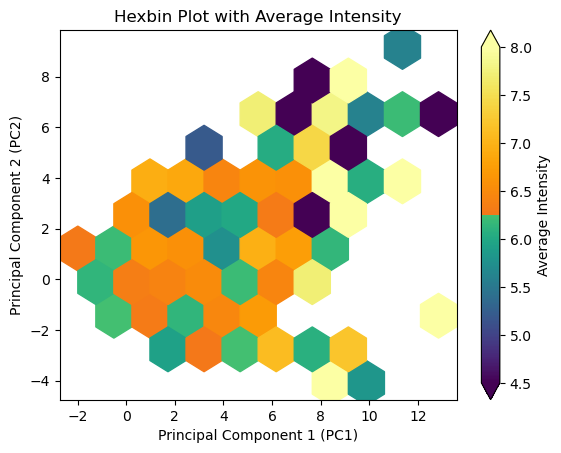

In [40]:
Years = actors_movies['ReleaseYearRange'].unique()
#Year40 = actors_movies[actors_movies['ReleaseYearRange'] == '1940 - 1950']
Year40 = actors_movies

 # Reset the index of Year to ensure alignment
Year40.reset_index(drop=True, inplace=True)

scaler = StandardScaler()
df_standardized = scaler.fit_transform(Year40[['awards', 'nominations', 'movie_count', 'genres_b4', 'isMale', 'age_at_release', 'actor_connections']].dropna())

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_standardized)

# Create a DataFrame with the PCA results
df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
df_pca['Rating'] = actors_movies['averageRating']

# Set custom vmin and vmax values
vmin = 4.5  # minimum value for the color scale
vmax = 8    # maximum value for the color scale

# Create a custom colormap
colors_below_6_2 = plt.cm.viridis(np.linspace(0, 0.7, 256))
colors_above_6_2 = plt.cm.inferno(np.linspace(0.7, 1, 256))
colors_combined = np.vstack((colors_below_6_2, colors_above_6_2))
custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors_combined)

# Create a hexbin plot with the custom colormap
hexbin = plt.hexbin(df_pca['PC1'], df_pca['PC2'], C=df_pca['Rating'], gridsize=10, cmap=custom_cmap, reduce_C_function=np.mean, vmin=vmin, vmax=vmax)
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('Hexbin Plot with Average Intensity')
plt.colorbar(hexbin, label='Average Intensity', extend='both')  # Add extend='both' to show color limits beyond the data range
plt.show()

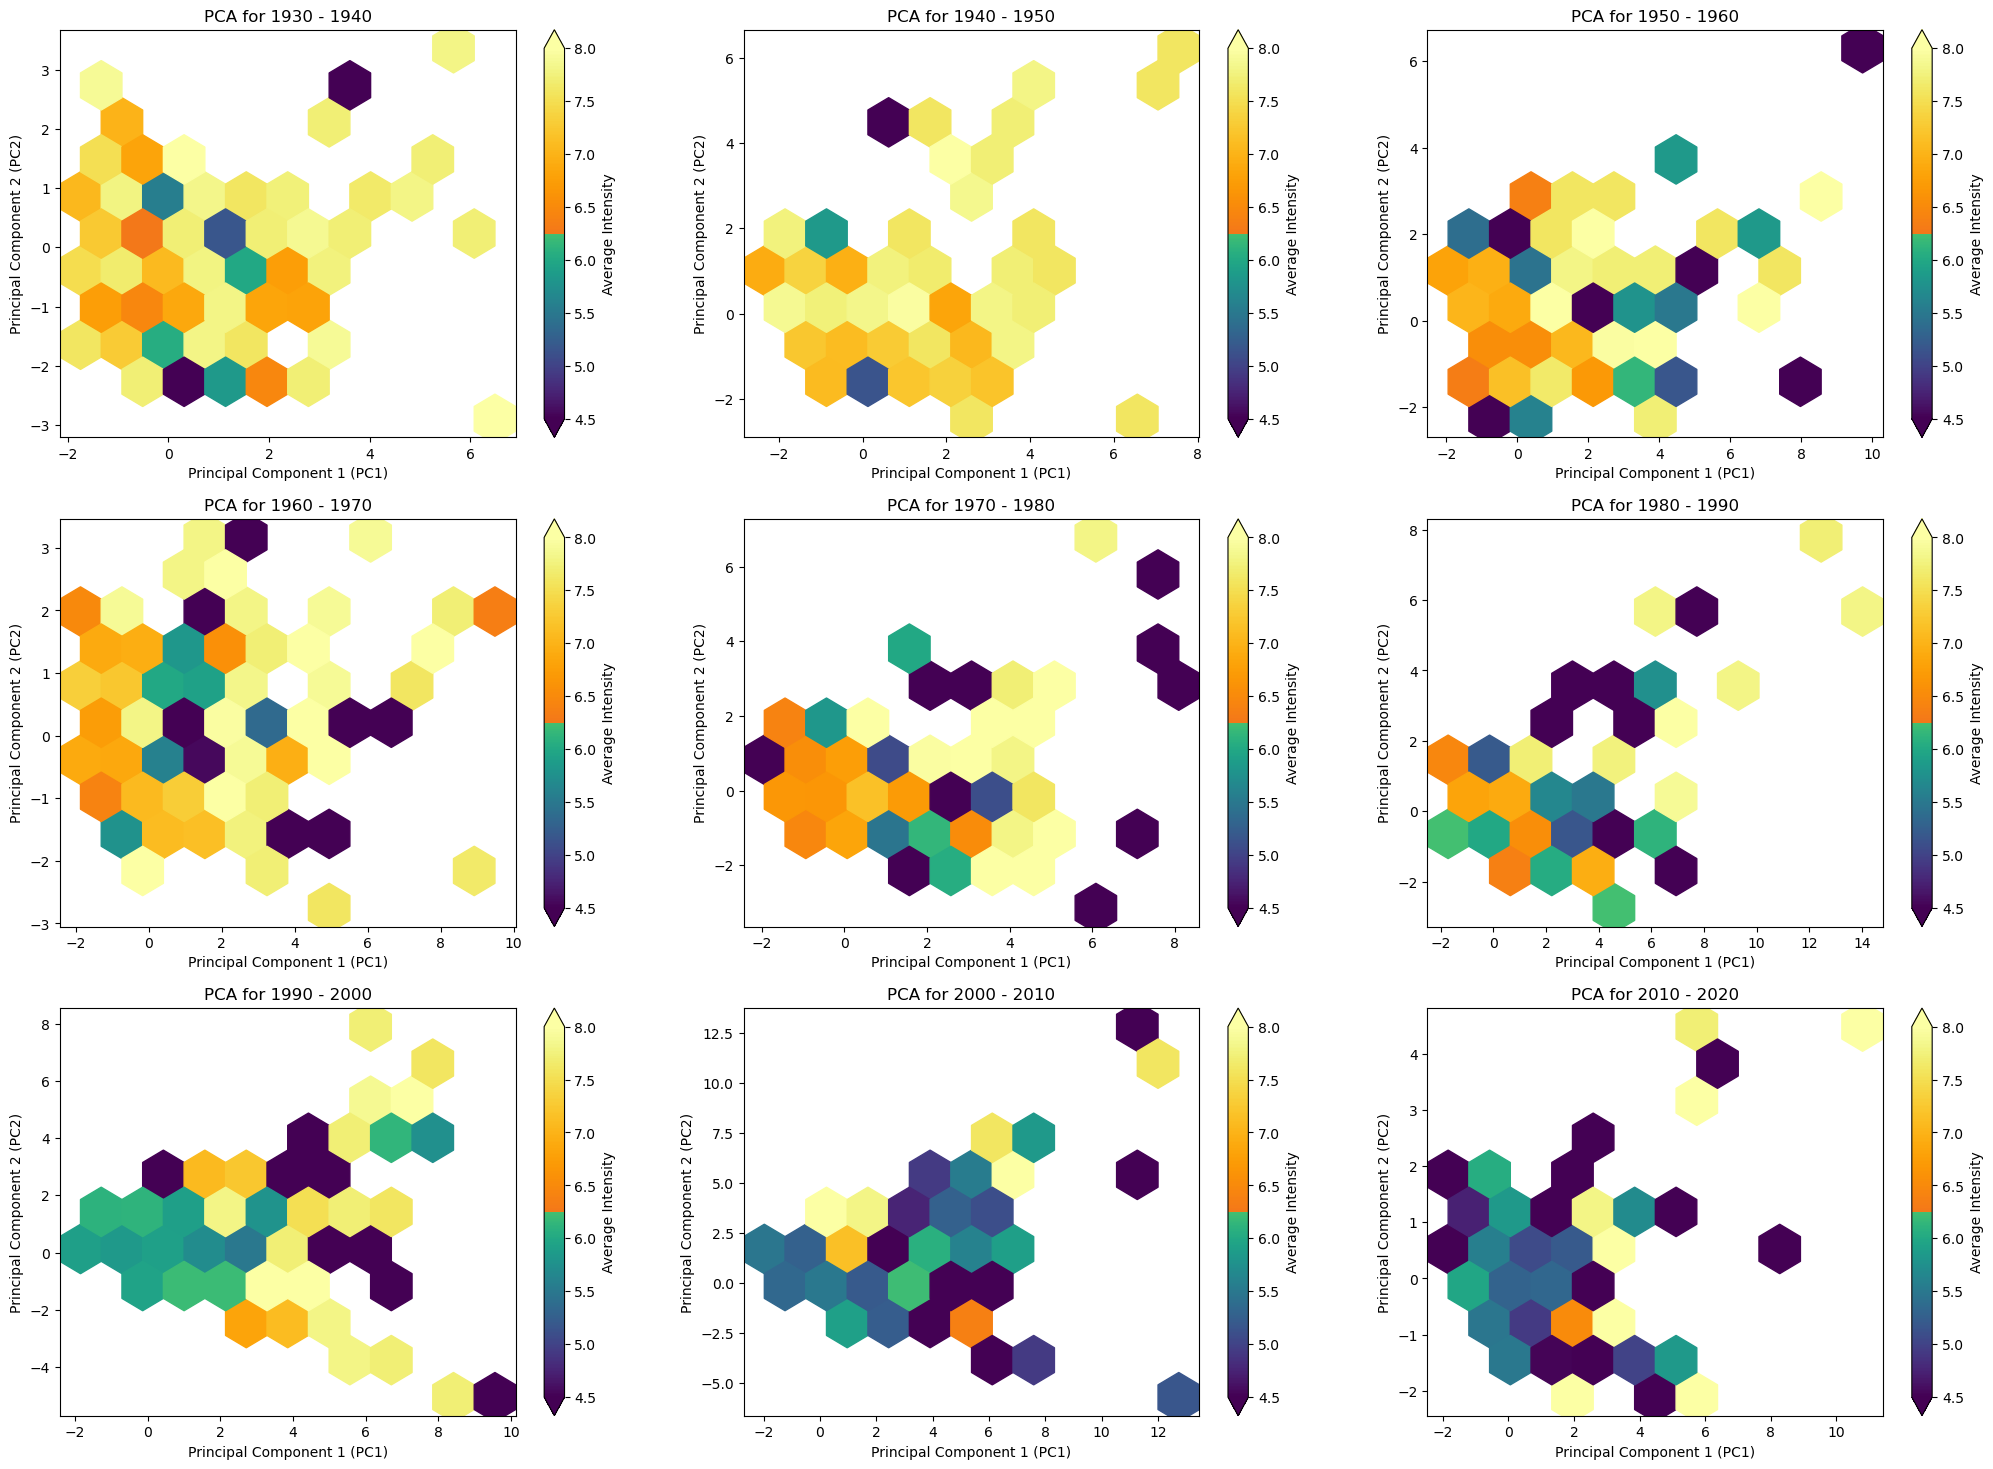

In [38]:
figs, axs = plt.subplots(3, 3, figsize=(25, 18))
axs = axs.flatten()
Years = actors_movies['ReleaseYearRange'].unique()

for i, year_range in enumerate(Years):
    Year = actors_movies[actors_movies['ReleaseYearRange'] == year_range]
    
    # Reset the index of Year to ensure alignment
    Year.reset_index(drop=True, inplace=True)

    scaler = StandardScaler()
    # Apply dropna() before scaling to ensure matching indices
    non_null_data = Year[['awards', 'nominations', 'movie_count', 'genres_b4', 'isMale', 'age_at_release', 'actor_connections']].dropna()
    #non_null_data = Year[['awards', 'nominations', 'movie_count', 'genres_b4', 'age_at_release']].dropna()
    df_standardized = scaler.fit_transform(non_null_data)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df_standardized)

    # Create a DataFrame with the PCA results
    df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
    # Use non_null_data.index to ensure correct alignment of ratings
    df_pca['Rating'] = Year.loc[non_null_data.index, 'averageRating']
    
    # Set custom vmin and vmax values
    vmin = 4.5  # minimum value for the color scale
    vmax = 8    # maximum value for the color scale
    
    # Create a custom colormap
    colors_below_6_2 = plt.cm.viridis(np.linspace(0, 0.7, 256))
    colors_above_6_2 = plt.cm.inferno(np.linspace(0.7, 1, 256))
    colors_combined = np.vstack((colors_below_6_2, colors_above_6_2))
    custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors_combined)
    
    # Create a hexbin plot with the custom colormap
    hexbin = axs[i].hexbin(df_pca['PC1'], df_pca['PC2'], C=df_pca['Rating'], gridsize=10, cmap=custom_cmap, reduce_C_function=np.mean, vmin=vmin, vmax=vmax)


    axs[i].set_xlabel('Principal Component 1 (PC1)')
    axs[i].set_ylabel('Principal Component 2 (PC2)')
    axs[i].set_title(f'PCA for {year_range}')
    plt.colorbar(hexbin, label='Average Intensity', extend='both')

    
plt.show()

# Conclusion and future work

In [ ]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import euclidean_distances
from sklearn.metrics import accuracy_score

In [33]:

actors_movies_agg =actors_movies[['awards','nominations', 'genres_b4','Movie release date', 'averageRating', 'actor_connections']].reset_index()
actors_movies_agg = actors_movies_agg.groupby('IMDb_ID').agg({'awards': 'sum', 'nominations': 'sum', 'genres_b4': 'sum','Movie release date':'mean', 'averageRating':'mean', 'actor_connections':'mean' }).reset_index()

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming you have already imported necessary libraries and defined X, y, and threshold

y = actors_movies_agg['averageRating'].to_numpy()
X = actors_movies_agg[['awards', 'nominations', 'genres_b4', 'Movie release date', 'actor_connections']].to_numpy()
threshold = 6
y = y > threshold

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Create an instance of the DecisionTreeClassifier
classifier = DecisionTreeClassifier()

# Fit the classifier with training data
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_predict = classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_predict)
print("Accuracy:", accuracy)


Accuracy: 0.6467124631992149


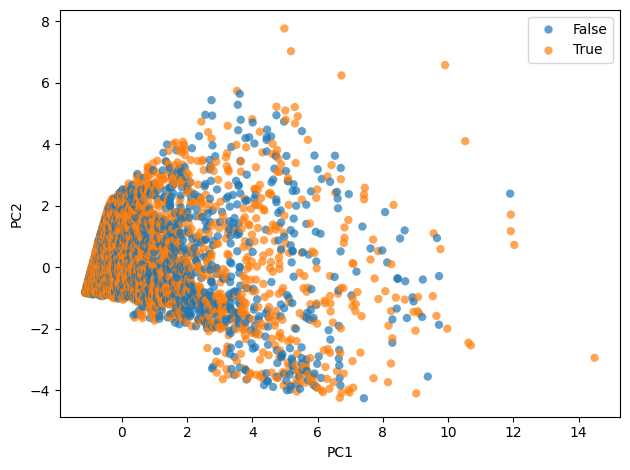

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming actors_movies is your original DataFrame

# actors_movies_1940 = actors_movies.query("ReleaseYearRange == '1940 - 1950'")

# Standardize the data
scaler = StandardScaler()
df_standardized = scaler.fit_transform(actors_movies[['Movie release date', 'has_nomination', 'has_award', 'movie_count', 'genres_b4', 'actor_connections']].dropna())

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_standardized)
df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
df_pca['is_good'] = actors_movies.reset_index()['is_good']
df_pca['year'] = actors_movies.reset_index()['Movie release date'].astype(float)  # Convert 'year' to float
# df_pca[['PC1','PC2']] = df_pca[['PC1','PC2']].round(1)


counts = df_pca.groupby(['PC1', 'PC2']).size().reset_index(name='Count')
counts['is_good'] = actors_movies.reset_index()['is_good']
counts['threshhold'] = counts['Count']>1



# Create subplots
# fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot for is_good == True with continuous hue based on 'year'
# plt.subplot(1, 2, 1)

# sns.scatterplot(data=counts[counts['is_good']== False], x='PC1', y='PC2', hue='is_good',  linewidth=0, sizes=(20, 1000), alpha= 0.5)
# plt.title('is_good == True')

# Plot for is_good == False with continuous hue based on 'year'
# plt.subplot(1, 2, 2)

# plt.title('is_good == False')
# sns.scatterplot(data=counts[counts['is_good']==True], x='PC1', y='PC2', hue='is_good',  linewidth=0, sizes=(20, 1000), alpha= 0.5)
sns.scatterplot(data=counts, x='PC1', y='PC2', hue='is_good',  linewidth=0, sizes=(20, 1000), alpha= 0.7)

# Place the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.legend()
plt.tight_layout()
plt.show()


# POUBELLE

[]

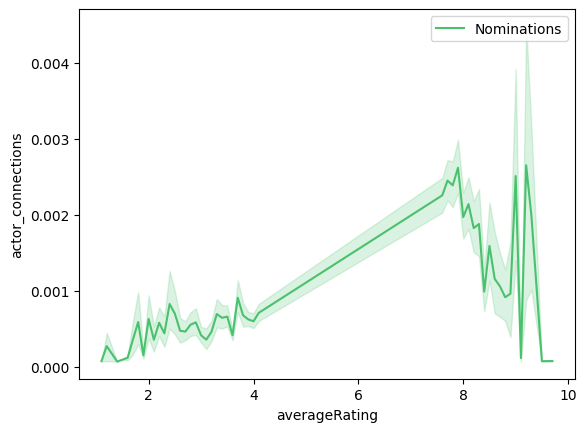

In [25]:
sns.lineplot(x='averageRating', y='actor_connections', data=actors_movies, errorbar=('ci', 95), label='Nominations',color=sns.color_palette('viridis')[4])
plt.plot()